In [46]:
# standard imports
import pandas as pd
import numpy as np
from collections import Counter

# plotting bits
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

import os

pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 100)

# stats packages to fit classification models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.calibration import calibration_curve

# importing xG xGils library
import xGils.xG as xG
from xGils import xT

# importing seaborn to get colourblind palette for calibration plots
import seaborn
palette = seaborn.color_palette('colorblind', 6).as_hex()

pd.options.mode.chained_assignment = None

# **xG Feature Engineering**

1. Load in pre-made Opta dataset.
2. Load in synthetic data.
2. Feature engineering of additional features:
    * "Basic" features;
    * "Added" features;
    * "Advanced" features;
    * "Advanced" features including synthetic shots.
3. Fit logistic / probit regression models.
4. Plot calibration curves.
5. Calculate model scores.
6. Apply xT to Opta dataset.
7. Output dataset.

**Note, we'll have to construct some of the features before we construct a `df_shots` dataframe.**

**Will also want to integrate the synthetic shots and see if that improves things.**
(Will have to generate some additional synthetic data for the synthetic shot dataset using appropriate distributions).

Take a look at this: https://twitter.com/Soccermatics/status/1260593848973172744?s=20

## **1) Loading Opta dataset (which includes Bayesian xT)**

In [ ]:
%%time

df = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Bayesian xT/Bayesian_Opta_xT.csv')

# converting the timestamp string to a datetime
df['timeStamp'] = pd.to_datetime(df.timeStamp, format='%Y-%m-%d %H:%M:%S.%f')
df['kickOffDateTime'] = pd.to_datetime(df.kickOffDateTime, format='%Y-%m-%d %H:%M:%S.%f')

print (f'{len(df)} rows loaded.\n')

### **Setting useful event types (may not need this)**

In [2]:
# pass events (inc. crosses)
opta_successful_pass_events = ['2nd Assist','Assist','Chance Created','Cross','Pass']
opta_failed_pass_events = ['Failed Pass','Offside Pass']

# dribble events
opta_successful_dribble_events = ['Dribble']
opta_failed_dribble_events = ['Failed Dribble']

# shot events
opta_successful_shot_events = ['Goal']
opta_failed_shot_events = ['Hit Woodwork','Miss','Missed Penalty','Penalty Saved','Shot Blocked','Shot Saved']

opta_events_successful = opta_successful_pass_events + opta_successful_dribble_events + opta_successful_shot_events
opta_events_relevant = opta_successful_pass_events + opta_failed_pass_events + opta_successful_dribble_events + opta_failed_dribble_events + opta_successful_shot_events + opta_failed_shot_events

opta_events_relevant

['2nd Assist',
 'Assist',
 'Chance Created',
 'Cross',
 'Pass',
 'Failed Pass',
 'Offside Pass',
 'Dribble',
 'Failed Dribble',
 'Goal',
 'Hit Woodwork',
 'Miss',
 'Missed Penalty',
 'Penalty Saved',
 'Shot Blocked',
 'Shot Saved']

## **2) Loading in Synthetic Shot Data**

In [3]:
df_synthetic = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Synthetic/Synthetic_Shots.csv')

## **3) Feature Engineering**

#### Binary Response Variable
* Shot success = 1 (`goalScoredFlag`)

#### Simple Features:
* Initial $x$-distance from goal (in metres), (`x_dist_goal`)
* Initial $y$-distance from the middle of the pitch (in metres), (`c1_m`)

#### Added Features:
* Angle from shooting position to the centre of the goal, (`a`)
* Amount of goal shooter can see, (`aShooting`)
* Distance to goal (metres), (`D`)
* Squared distance to goal (metres$^2$), (`Dsquared`)

#### Advanced (Contextual) Features:
* Game state (the point-in-time difference in goals between the two sides), (`goalDelta`)
* Headcount difference due to red cards (e.g. is equal to 1 if 11 Vs 10), (`numReds`)
* Player possession duration, (`playerPossessionTimeSec`)
* Cumulative team possession sequence duration, (`possessionTimeSec`)
* Binary penalty flag (`penaltyFlag`)
* Count of defenders providing defensive pressure on the shot (`pressureCountOnShot`)

### Contextual Features as Proxies:
* Using cumulative team possession sequence duration as a proxy for a counter attack / how set the opposing team is in defence.
* Using player possession duration as a proxy for how quickly the player took the shot after receiving the ball.
* Count of defenders applying shot pressure a proxy for how open the shot is.

**Didn't include previous action as 2nd assists and assists are by definition going to result in a goal, whereas passes and crosses aren't. Don't have separate labels.**

### **Applying Contextual Feature Engineering Functions**

In [ ]:
%%time

df = xG.xG_contextual_feature_engineering(df)

### **Applying Geometric Feature Engineering Functions**

In [ ]:
%%time

df_shots = xG.xG_geometric_shot_feature_engineering(df)

### **Saving & Loading the Engineered Shot Data**

In [7]:
#df.to_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Engineered Shots/Engineered Events.csv', index=None)
#df_shots.to_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Engineered Shots/Engineered Shots.csv', index=None)

In [196]:
%%time

df = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Engineered Shots/Engineered Events.csv')
df_shots = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Engineered Shots/Engineered Shots.csv')

# converting the timestamp string to a datetime
df['timeStamp'] = pd.to_datetime(df.timeStamp, format='%Y-%m-%d %H:%M:%S.%f')
df['kickOffDateTime'] = pd.to_datetime(df.kickOffDateTime, format='%Y-%m-%d %H:%M:%S.%f')

# converting the timestamp string to a datetime for shots
df_shots['timeStamp'] = pd.to_datetime(df_shots.timeStamp, format='%Y-%m-%d %H:%M:%S.%f')
df_shots['kickOffDateTime'] = pd.to_datetime(df_shots.kickOffDateTime, format='%Y-%m-%d %H:%M:%S.%f')

# excluding pens
df_pens = df_shots.loc[df_shots['penaltyFlag'] == 1].reset_index(drop=True).copy()
df_shots = df_shots.loc[df_shots['penaltyFlag'] == 0].reset_index(drop=True).copy()

CPU times: user 19.2 s, sys: 2.54 s, total: 21.7 s
Wall time: 22.3 s


---

### **Adding in the synthetic data**

* Want to create randomly sampled data for the new contextual features:
    * goalDelta
    * numReds
    * possessionTimeSec
    * playerPossessionTimeSec
    
* Then, because of the positional nature of the synthetic shot data being outside of the box, we can make the safe assumption that there will be 0 penalties in the synthetic data, and the slightly more fluffy assumption that there will be 0 pressures on any of the synthetic shots.
* And will then push it through the geometric function to add the geometric features.

In [197]:
np.random.seed(0)

# adding some flags to enable differentiation between real and synthetic shots
df_synthetic['eventType'] = 'shot'
df_synthetic['realOrSynthetic'] = 'synthetic'
df_synthetic['goalScoredFlag'] = df_synthetic.goal

# synthesising goalDelta: sampling from normal distribution and rounding to nearest integer
df_synthetic['goalDelta'] = np.round(np.random.normal(loc=df_shots.goalDelta.mean(), scale=df_shots.goalDelta.std(), size=len(df_synthetic)), 0).astype(int)

# synthesising numReds: sampling from normal and rounding to nearest integer
df_synthetic['numReds'] = np.round(np.random.normal(loc=df_shots.numReds.mean(), scale=df_shots.numReds.std(), size=len(df_synthetic)), 0).astype(int)

# synthesising possessionTimeSec by simulating from exponential with scale = mean (possessionTimeSec is a lifetime)
df_synthetic['possessionTimeSec'] = np.random.exponential(scale=df_shots.possessionTimeSec.mean(), size=len(df_synthetic))

# synthesising playerPossessionTimeSec by simulating from an exponential with scale = mean (playerPossessionTimeSec is a lifetime)
df_synthetic['playerPossessionTimeSec'] = np.random.exponential(scale=df_shots.playerPossessionTimeSec.mean(), size=len(df_synthetic))

# penaltyFlag, setting to 0 for all synthetic shots because all synthetic shots are taken outside the box
df_synthetic['penaltyFlag'] = 0

# pressureCountOnShot, simulating these from a poisson
df_synthetic['pressureCountOnShot'] = np.random.poisson(lam=df_shots.pressureCountOnShot.mean(), size=len(df_synthetic))

# passing the synthetic shots dataframe through the geometric shot feature engineering function
## dropping the "goal" column so that we can easily concatenate the synthetic shots with the real shots
df_synthetic_enriched = xG.xG_geometric_synthetic_shot_feature_engineering(df_synthetic).drop(columns='goal')

# concatenating real and synthetic shots
## starting by just copying the real shots
df_shots_incl_synthetic = df_shots.copy()
## marking real shots as real
df_shots_incl_synthetic['realOrSynthetic'] = 'real'
## then mixing real and synthetic shots
df_shots_incl_synthetic = pd.concat([df_shots_incl_synthetic[df_synthetic_enriched.columns], df_synthetic_enriched]).reset_index(drop=True).copy()

### **Model Fitting**

#### Splitting `df_shots` into training and test dataset, stratifying the dependent variable

In [198]:
# splitting into a dataframe for training and dataframe for testing
## stratifying the successFlag

test_size = 0.25
random_state = 40

# producing stratified training and test samples
df_shots_train, df_shots_test = train_test_split(df_shots, test_size=test_size, stratify=df_shots.goalScoredFlag, random_state=random_state, shuffle=True)

# and adding synthetic shots data to the training synthetic sample (NOTE: THE TEST DATA DOES NOT CHANGE WHATSOEVER)
df_shots_train['realOrSynthetic'] = 'real'
df_shots_train_synthetic = pd.concat([df_shots_train[df_synthetic_enriched.columns], df_synthetic_enriched]).reset_index(drop=True).copy()

# manual patch of two goals that are causing havoc because they're such outliers -> TODO: just get rid of them from the full dataset (Vs the test dataset which is obviously wrong)
#df_shots_test.loc[(df_shots_test['x1_m'] > 70) & (df_shots_test['y1_m'] < 5), 'goalScoredFlag'] = 0

print (f'Stratified Shot Success Rates:\n\nOverall: {100*np.round(df_shots.goalScoredFlag.mean(),3)}%\nTrain: {100*np.round(df_shots_train.goalScoredFlag.mean(), 3)}%\nTest: {100*np.round(df_shots_test.goalScoredFlag.mean(), 3)}%\n')

Stratified Shot Success Rates:

Overall: 10.2%
Train: 10.2%
Test: 10.100000000000001%



In [199]:
df_shots_train.to_csv('R_shots_train.csv', index=None)
df_shots_train_synthetic.to_csv('R_shots_train_synthetic.csv', index=None)
df_shots_test.to_csv('R_shots_test.csv', index=None)

### **Fitting basic model to training data**:

In [200]:
%%time

xG_model_basic = smf.glm(formula="goalScoredFlag ~ x_dist_goal + c1_m", data=df_shots_train\
                 ,family=sm.families.Binomial()).fit()

xG_model_basic.summary2()

CPU times: user 394 ms, sys: 57.1 ms, total: 451 ms
Wall time: 110 ms


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:              GLM              AIC:            19268.3991  
Link Function:      logit            BIC:            -318884.0958
Dependent Variable: goalScoredFlag   Log-Likelihood: -9631.2     
Date:               2021-08-13 17:19 LL-Null:        -10695.     
No. Observations:   32547            Deviance:       19262.      
Df Model:           2                Pearson chi2:   3.55e+04    
Df Residuals:       32544            Scale:          1.0000      
Method:             IRLS                                         
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept    -0.2546    0.0441   -5.7710  0.0000  -0.3411  -0.1682
x_dist_goal  -0.1006    0.0030  -33.0589  0.0000  -0.1065  -0.0946
c1_m         -0.1036    0.0047  -21.8509  0.0000  -0.1129  -0.0943
=================================================================

"""

### **Fitting additional features:**

In [201]:
%%time

xG_model_added = smf.glm(formula="goalScoredFlag ~ c1_m + aShooting + D + a", data=df_shots_train\
                 ,family=sm.families.Binomial()).fit()

xG_model_added.summary2()

CPU times: user 745 ms, sys: 118 ms, total: 863 ms
Wall time: 169 ms


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:              GLM              AIC:            19030.1579  
Link Function:      logit            BIC:            -319105.5561
Dependent Variable: goalScoredFlag   Log-Likelihood: -9510.1     
Date:               2021-08-13 17:19 LL-Null:        -10695.     
No. Observations:   32547            Deviance:       19020.      
Df Model:           4                Pearson chi2:   3.48e+04    
Df Residuals:       32542            Scale:          1.0000      
Method:             IRLS                                         
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept      2.9071    0.6879   4.2263  0.0000   1.5589   4.2553
c1_m          -0.1937    0.0252  -7.6810  0.0000  -0.2432  -0.1443
aShooting      1.7646    0.1005  17.5648  0.0000   1.5677   1.9615
D             -0.1665    0.0227  -7.3301  0.0000  -0.2110  -0.1220
a              0.9768    0.4178   2.3376  0.0194   0.1578   1.7957
=================================================================

"""

In [202]:
%%time

xG_formula_adv = "goalScoredFlag ~   a + aShooting + D + Dsquared +\
                    possessionTimeSec + goalDelta + numReds + pressureCountOnShot +\
                    D*aShooting + D*a"

xG_model_adv = smf.glm(formula=xG_formula_adv, data=df_shots_train\
                 ,family=sm.families.Binomial()).fit()

xG_model_adv_feat_on_syn = smf.glm(formula=xG_formula_adv, data=df_shots_train_synthetic\
                         ,family=sm.families.Binomial()).fit()

xG_model_adv.summary2()

CPU times: user 3.76 s, sys: 552 ms, total: 4.31 s
Wall time: 780 ms


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:                GLM              AIC:            16522.4918  
Link Function:        logit            BIC:            -321562.8795
Dependent Variable:   goalScoredFlag   Log-Likelihood: -8250.2     
Date:                 2021-08-13 17:19 LL-Null:        -10695.     
No. Observations:     32547            Deviance:       16500.      
Df Model:             10               Pearson chi2:   3.12e+04    
Df Residuals:         32536            Scale:          1.0000      
Method:               IRLS                                         
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           -6.5943   0.8473 -7.7830 0.0000 -8.2550 -4.9337
a                    5.5505   1.0756  5.1602 0.0000  3.4423  7.6587
aShooting            6.7288   1.2510  5.3789 0.0000  4.2770  9.1807
D                    0.0639   0.0463  1.3794 0.1678 -0.0269  0.1546
Dsquared             0.0022   0.0009  2.5904 0.0096  0.0005  0.0039
possessionTimeSec   -0.0019   0.0008 -2.3963 0.0166 -0.0035 -0.0003
goalDelta            0.7354   0.0160 46.0277 0.0000  0.7041  0.7667
numReds             -0.3376   0.1241 -2.7198 0.0065 -0.5809 -0.0943
pressureCountOnShot -1.3742   0.3619 -3.7969 0.0001 -2.0836 -0.6648
D:aShooting         -0.1643   0.0388 -4.2295 0.0000 -0.2404 -0.0882
D:a                 -0.2466   0.0360 -6.8420 0.0000 -0.3172 -0.1759
===================================================================

"""

In [203]:
%%time

xG_formula_adv_syn = "goalScoredFlag ~  a + aShooting + D + Dsquared +\
                    possessionTimeSec + playerPossessionTimeSec + goalDelta + numReds + pressureCountOnShot +\
                    D*aShooting + Dsquared*a"

xG_model_adv_syn = smf.glm(formula=xG_formula_adv_syn, data=df_shots_train_synthetic\
                 ,family=sm.families.Binomial()).fit()

xG_model_adv_syn.summary2()

CPU times: user 2.91 s, sys: 449 ms, total: 3.36 s
Wall time: 685 ms


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Generalized linear model
========================================================================
Model:                 GLM                AIC:              17354.8682  
Link Function:         logit              BIC:              -841066.0555
Dependent Variable:    goalScoredFlag     Log-Likelihood:   -8665.4     
Date:                  2021-08-13 17:19   LL-Null:          -13771.     
No. Observations:      76360              Deviance:         17331.      
Df Model:              11                 Pearson chi2:     6.75e+04    
Df Residuals:          76348              Scale:            1.0000      
Method:                IRLS                                             
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Intercept               -8.7139   0.5090 -17.1202 0.0000 -9.7114 -7.7163
a                        0.3859   0.3184   1.2121 0.2255 -0.2381  1.0100
aShooting                6.1683   1.0721   5.7537 0.0000  4.0671  8.2695
D                        0.2379   0.0337   7.0689 0.0000  0.1719  0.3039
Dsquared                -0.0008   0.0007  -1.0509 0.2933 -0.0022  0.0007
possessionTimeSec       -0.0025   0.0008  -2.9289 0.0034 -0.0041 -0.0008
playerPossessionTimeSec  0.0056   0.0024   2.3757 0.0175  0.0010  0.0103
goalDelta                0.7173   0.0157  45.7917 0.0000  0.6866  0.7480
numReds                 -0.3135   0.1246  -2.5168 0.0118 -0.5577 -0.0694
pressureCountOnShot     -1.0252   0.2204  -4.6523 0.0000 -1.4571 -0.5933
D:aShooting             -0.1543   0.0333  -4.6416 0.0000 -0.2195 -0.0892
Dsquared:a              -0.0031   0.0004  -8.7353 0.0000 -0.0038 -0.0024
========================================================================

"""

---

### **Applying *four* xG models to *test* data**

In [204]:
df_shots_test = xG.apply_xG_model_to_test(df_shots_test, [xG_model_basic, xG_model_added, xG_model_adv, xG_model_adv_syn, xG_model_adv_feat_on_syn])

Applying models...
Done applying 5 models.


---


### **Model Validation: Calibration Curves of Models Fit to Test Data**

### Calibration Curve: Basic Vs Added Models

/Users/christian/anaconda2/envs/py37_football/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


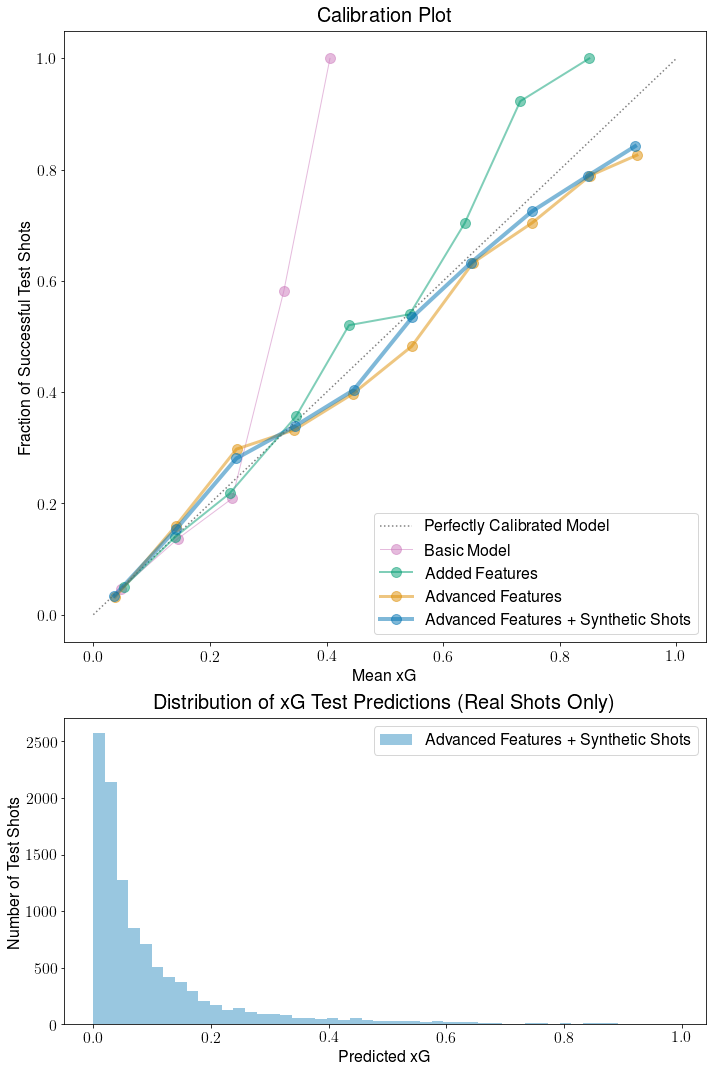

In [205]:
xG.plot_calibration_curve(df_shots_test, numBins=10, alpha=0.5, saveOutput=0, plotName='xG_calibration_incl_synthetic_shots',calibrationType='uniform')

---

### **Applying Logistic Regression Classifier and Calculating Model Fit Metrics**

In [206]:
df_shots_test.xG_basic.apply(lambda x: 1 if x >= 0.5 else 0).sum()

0

In [207]:
df_shots_test.xG_added.apply(lambda x: 1 if x >= 0.5 else 0).sum()

98

In [208]:
df_shots_test.xG_adv.apply(lambda x: 1 if x >= 0.5 else 0).sum()

325

In [209]:
df_shots_test.xG_syn.apply(lambda x: 1 if x >= 0.5 else 0).sum()

305

In [210]:
df_shots_test.goalScoredFlag.values.sum()

1100

In [211]:
xG.calculate_model_metrics(df_shots_test, 'xG_basic', log_reg_decision_threshold=0.5)

LogLoss Score: 0.2932331428821469

Brier Score: 0.0835536631384952

Precision Score: 0.0

Recall Score: 0.0

F1 Score: 0.0

AUC Score: 0.7401166086964631

AccuracyScore: 0.8986081666513043


/Users/christian/anaconda2/envs/py37_football/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [212]:
xG.calculate_model_metrics(df_shots_test, 'xG_added', log_reg_decision_threshold=0.5)

LogLoss Score: 0.2878948513893396

Brier Score: 0.08152446128472268

Precision Score: 0.673469387755102

Recall Score: 0.06

F1 Score: 0.11018363939899833

AUC Score: 0.7460283105959586

AccuracyScore: 0.9017420960457185


In [213]:
xG.calculate_model_metrics(df_shots_test, 'xG_adv', log_reg_decision_threshold=0.5)

LogLoss Score: 0.25168921395396626

Brier Score: 0.07335535151462942

Precision Score: 0.6092307692307692

Recall Score: 0.18

F1 Score: 0.2778947368421053

AUC Score: 0.8392440716530367

AccuracyScore: 0.9051525486219928


In [214]:
xG.calculate_model_metrics(df_shots_test, 'xG_adv_on_syn', log_reg_decision_threshold=0.5)

LogLoss Score: 0.2528028983746906

Brier Score: 0.07335976287214183

Precision Score: 0.6295081967213115

Recall Score: 0.17454545454545456

F1 Score: 0.2733096085409253

AUC Score: 0.835143417972939

AccuracyScore: 0.9058899437736196


In [215]:
xG.calculate_model_metrics(df_shots_test, 'xG_syn', log_reg_decision_threshold=0.5)

LogLoss Score: 0.2527856524279532

Brier Score: 0.07331332102559332

Precision Score: 0.6360655737704918

Recall Score: 0.17636363636363636

F1 Score: 0.2761565836298932

AUC Score: 0.8349231622823787

AccuracyScore: 0.9062586413494331


### Calculating Log Loss per Zone

In [216]:
w, l = 8, 12

lst_z = np.unique(xT.get_flat_indexes(df_shots_test.x1, df_shots_test.y1, l=l, w=w))

df_shots_test['z'] = xT.get_flat_indexes(df_shots_test.x1, df_shots_test.y1, l=l, w=w)

lst_features = ['xG_basic','xG_added','xG_adv','xG_adv']
lst_matrix_ll = []

# iterating through features
for feature in lst_features:
    
    # will store the logloss measure PER ZONE here
    lst_ll = []
    
    # looping through the zones
    for z in lst_z:
        df_ll = df_shots_test.loc[df_shots_test['z'] == z].copy()
        ll = metrics.log_loss(df_ll.goalScoredFlag, df_ll[feature], labels=[0,1])
        lst_ll.append(ll)
        
    # transforming list of log losses into series that's indexed on the zone
    ll = pd.Series(data=lst_ll, index=lst_z)
    # creating empty mxn column vector
    m_x_n_counts = np.zeros(w * l)
    # populating vector with log losses (those unpopulated are zero)
    m_x_n_counts[ll.index] = ll
    # reshaping to an mxn matrix
    ll_matrix = m_x_n_counts.reshape((w, l))
    # appending matrix to list
    lst_matrix_ll.append(ll_matrix)
    

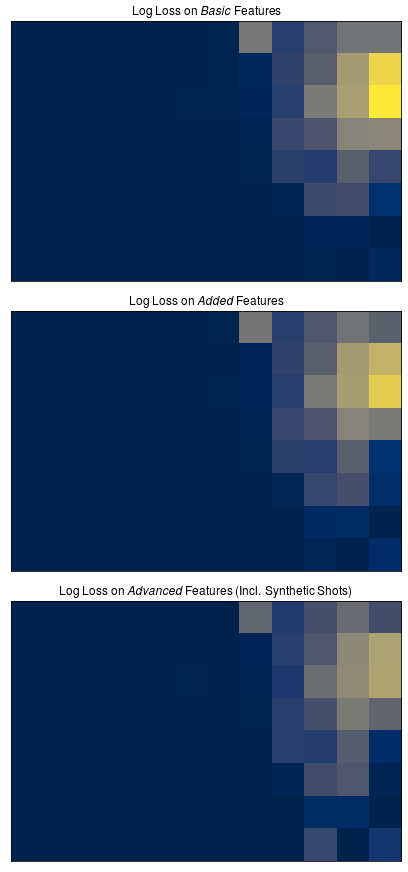

In [217]:

## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

fig = plt.figure(constrained_layout=True, figsize=(6,12))
gs = fig.add_gridspec(3,1)

set_vmax = 0.7

ax1 = fig.add_subplot(gs[0:1, 0:1])
plt.imshow(lst_matrix_ll[0], interpolation='nearest', cmap=cm.cividis, vmin=0, vmax=set_vmax)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.set_title('Log Loss on \\textit{Basic} Features')

ax2 = fig.add_subplot(gs[1:2, 0:1])
plt.imshow(lst_matrix_ll[1], interpolation='nearest', cmap=cm.cividis, vmin=0, vmax=set_vmax)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.set_title('Log Loss on \\textit{Added} Features')

ax3 = fig.add_subplot(gs[2:3, 0:1])
plt.imshow(lst_matrix_ll[3], interpolation='nearest', cmap=cm.cividis, vmin=0, vmax=set_vmax)
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
ax3.set_title('Log Loss on \\textit{Advanced} Features (Incl. Synthetic Shots)')

#ax4 = fig.add_subplot(gs[3:4, 0:1])
#plt.imshow(lst_matrix_ll[3], interpolation='nearest', cmap=cm.coolwarm, vmin=0, vmax=set_vmax)
#ax4.axes.get_xaxis().set_visible(False)
#ax4.axes.get_yaxis().set_visible(False)
#ax4.set_title('Move Transition Matrix, $T_{z \\rightarrow z\'}$')

plt.savefig('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/xG Calibration/LogLossMatrix.png', dpi=300)

---

### **Applying xG Model (*Trained Using Advanced Features + Synthetic Shots*) to All Real Shots** 

In [218]:
df_shots['xG'] = xG_model_adv_syn.predict(df_shots_test)

### **For penalties, just apply the mean penalty conversion ratio**

In [219]:
df_pens['xG'] = df_pens.goalScoredFlag.mean()

# and now combining shots and penalties
df_shots_pens = pd.concat([df_shots, df_pens], ignore_index=True)

### **Important Modelling Points**

We have created sufficiently well-calibrated logistic models both with and without the synthetic shots.

The number of bins is a subjective decision, but changing the number of bins does not change the interpretation of the calibration of the model.

Model is very well-calibrated towards the lower end of the continuum, where the vast majority of the shots are taken from. Despite having over 40k shote, the number of shots with xG of over 0.5 are still very sparse.

Should also note that the model **globally calibrated** except for penalties. Meaning we have not fit different xG models for headers / strong or weak foot, and so we've not **explored conditional calibration**, and have treated penalties fairly simplistically.

**Where domain expertise comes in:**
* In the data: using the synthetic data that encapsultes knowledge of where shots aren't taken from because they wouldn't result in a goal (and hense why there aren't any shots in the real data to show for it). Helps to prevent overfitting when real goals go in in bizarre situations.
* In the model: handcrafted advanced features that add off-the-ball context to the on-the-ball data via proxies.

There's also a second benefit to the synthetic data: we can push the non-linear distance terms into the model, which is why we see the interaction term of `Dsquared` and `aShooting` but it doesn't appear in the advanced  model without the synthetic data.

### **Creating a Simple Dataframe `df_xG` Just Containing `eventId` & `xG` Columns**

In [829]:
df_xG = df_shots_pens[['eventId','xG']].reset_index(drop=True).copy()

### **And Now Joining `df_xG` Back OnTo Original `df`.**

> **All non-shots will get an xG of 0**

> `excess_xG` defined as `goalScoredFlag` - `xG`

In [830]:
df_xG = df.merge(df_xG, on=['eventId'], how='left').copy()

# filling NaN's with 0's
df_xG.xG.fillna(value=0, inplace=True)

In [831]:
df_xG['excess_xG'] = df_xG.goalScoredFlag - df_xG.xG

### **Outputting data to CSV**

In [832]:
df.columns

Index(['competition', 'season', 'seasonIndex', 'gameMonthIndex', 'matchId',
       'playerId', 'playerName', 'position', 'detailedPosition',
       'playerTeamId', 'minsPlayed', 'subIn', 'subOut',
       'replacedReplacingPlayerId', 'booking', 'eventId', 'eventType',
       'eventSubType', 'eventTypeId', 'x1', 'y1', 'x2', 'y2', 'gameTime',
       'timeStamp', 'periodId', 'homeTeamName', 'homeTeamId', 'awayTeamName',
       'awayTeamId', 'kickOffDateTime', 'minute', 'second', 'x1_m', 'y1_m',
       'x2_m', 'y2_m', 'possessionTeamId', 'possessionSequenceIndex',
       'possessionStartTime', 'possessionTimeSec', 'playerPossessionTimeSec',
       'goalDelta', 'numReds', 'goalScoredFlag', 'xT'],
      dtype='object')

In [833]:
df_xG.columns

Index(['competition', 'season', 'seasonIndex', 'gameMonthIndex', 'matchId',
       'playerId', 'playerName', 'position', 'detailedPosition',
       'playerTeamId', 'minsPlayed', 'subIn', 'subOut',
       'replacedReplacingPlayerId', 'booking', 'eventId', 'eventType',
       'eventSubType', 'eventTypeId', 'x1', 'y1', 'x2', 'y2', 'gameTime',
       'timeStamp', 'periodId', 'homeTeamName', 'homeTeamId', 'awayTeamName',
       'awayTeamId', 'kickOffDateTime', 'minute', 'second', 'x1_m', 'y1_m',
       'x2_m', 'y2_m', 'possessionTeamId', 'possessionSequenceIndex',
       'possessionStartTime', 'possessionTimeSec', 'playerPossessionTimeSec',
       'goalDelta', 'numReds', 'goalScoredFlag', 'xT', 'xG', 'excess_xG'],
      dtype='object')

In [834]:
# uploading the final xT & xG file
df_xG.to_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Bayesian xT & xG/Bayesian_Opta_xT_xG.csv')

---

### **Quick look at the data - Will explore more when producing player-specific plots**

In [835]:
df_xG_agg = df_xG.groupby(['season','playerTeamId','playerName']).agg({'excess_xG':np.sum}).reset_index().sort_values('excess_xG', ascending=False)

df_xG_agg['excess_xG_rank'] = df_xG_agg.sort_values(['season','excess_xG'], ascending=[True,False]).groupby('season').cumcount()+1

df_xG_agg.loc[df_xG_agg['excess_xG_rank'] <= 25].sort_values(['season','excess_xG_rank'], ascending=[True,True])

,season,playerTeamId,playerName,excess_xG,excess_xG_rank
212,2017/18,14,Mohamed Salah,25.521387,1
94,2017/18,6,Harry Kane,17.133622,2
217,2017/18,14,Sadio Mané,14.184069,3
384,2017/18,43,Raheem Sterling,14.127624,4
183,2017/18,13,Jamie Vardy,12.290623,5
216,2017/18,14,Roberto Firmino,11.399603,6
22,2017/18,1,Romelu Lukaku,11.195289,7
385,2017/18,43,Sergio Agüero,10.085387,8
374,2017/18,43,Gabriel Jesus,9.795329,9
712,2017/18,186,Cristiano Ronaldo,9.333836,10
